In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.optim import Optimizer
from pytorch_forecasting.models import DeepAR
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE,RMSE

In [3]:
use_col = ['volumn','datetime']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
# data.rename({'service_name':'group_ids','datetime':'b','volumn':'value','packets':'c','unknown':'d'},axis=1,inplace=True)
# data.drop(columns=['b','c','d'],inplace=True)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['group_ids']=np.tile('0',len(data))
data['time_idx']=np.arange(len(data))
data['value'] = data['value'] * 8 / 1000000
data['datetime'] = pd.to_datetime(data['datetime'])
data["day_of_week"] = data.datetime.dt.dayofweek.astype(str).astype("category")
data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.datetime.dt.month.astype(str).astype("category")  # categories have be strings
data['time'] = np.tile(np.arange(1440),27) #1일이 1440으로 돼있으므로
data['time'] = data['time'].astype(str).astype("category") # numpy에 astype적용시 적용이 안된다
data

/tmp/ipykernel_416855/1261976885.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week_of_year"] = data.datetime.dt.weekofyear.astype(str).astype("category")  # categories have be strings


,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
0,2018-07-25 00:00:00,22.041608,0,0,2,30,7,0
1,2018-07-25 00:01:00,22.048000,0,1,2,30,7,1
2,2018-07-25 00:02:00,22.047176,0,2,2,30,7,2
3,2018-07-25 00:03:00,22.042408,0,3,2,30,7,3
4,2018-07-25 00:04:00,22.049328,0,4,2,30,7,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,22.316160,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,22.305744,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,22.318160,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,22.310040,0,38878,0,34,8,1438


<AxesSubplot: >

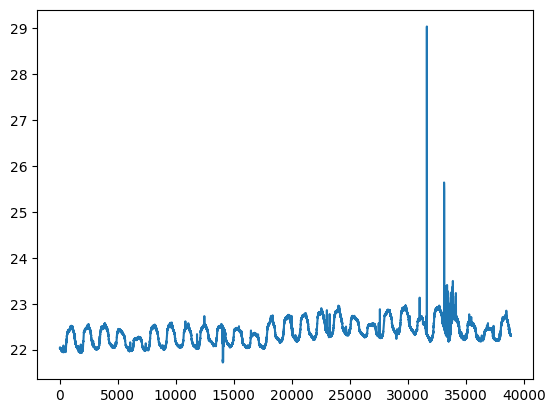

In [4]:
data['value'].plot()

In [5]:
Train_data = data.iloc[:28800]
Test_data = data.iloc[28800:]

In [6]:
encoder_length =1440
prediction_length=10080 # encoding 기간은 1일 prediction 기간은 7일

In [7]:
training = TimeSeriesDataSet(
    data=Train_data,
    max_encoder_length = encoder_length,
    min_encoder_length=1,
    max_prediction_length = prediction_length,
    min_prediction_length=1,
    target = 'value',
    group_ids = ['group_ids'],
    time_idx = 'time_idx',
    time_varying_known_categoricals=["week_of_year", "day_of_week","month","time"],
    time_varying_unknown_reals = ['value'],
    time_varying_known_reals = ['time_idx'],
    add_relative_time_idx = True,  # add as feature
    add_target_scales = True,  # add as feature
    add_encoder_length = True,  # add as feature
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True),
        'day_of_week':NaNLabelEncoder(add_nan=True),
        'month':NaNLabelEncoder(add_nan=True),
        'time':NaNLabelEncoder(add_nan=True)
    }
# NaNLableEncoder(add_nan=True)를 쓰지 않으면 새로운 categorical 변수에 대처 불가능
# https://stackoverflow.com/questions/74621525/temporal-fusion-transformer
# https://stackoverflow.com/questions/71098518/unknown-category-2-encountered-set-add-nan-true-to-allow-unknown-categories
)

In [8]:
batch_size = 64
train_dataloader = training.to_dataloader(train=False, batch_size = batch_size,num_workers = 0)

In [9]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping
import pytorch_lightning as pl
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 5, verbose = True, mode = "min")
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
net = DeepAR.from_dataset(training,
                         rnn_layers = 2,
                         hidden_size = 16,
                         optimizer = 'adam',
                         )

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [11]:
import torch

DEVICE = torch.device("cuda:0")

net.to(DEVICE)

DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {'week_of_year': {'nan': 0, '30': 1, '31': 2, '32': 3, '33': 4}, 'day_of_week': {'nan': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7}, 'month': {'nan': 0, '7': 1, '8': 2}, 'time': {'nan': 0, '0': 1, '1': 2, '10': 3, '100': 4, '1000': 5, '1001': 6, '1002': 7, '1003': 8, '1004': 9, '1005': 10, '1006': 11, '1007': 12, '1008': 13, '1009': 14, '101': 15, '1010': 16, '1011': 17, '1012': 18, '1013': 19, '1014': 20, '1015': 21, '1016': 22, '1017': 23, '1018': 24, '1019': 25, '102': 26, '1020': 27, '1021': 28, '1022': 29, '1023': 30, '1024': 31, '1025': 32, '1026': 33, '1027': 34, '1028': 35, '1029': 36, '103': 37, '1030': 38, '1031': 39, '1032': 40, '1033': 41, '1034': 42, '1035': 43, '1036': 44, '1037': 45, '1038': 46, '1039': 47, '104': 48, '1040': 49, '1041': 50, '1042': 51, '1043': 52, '1044': 53, '1

In [14]:
model=trainer.fit(net,train_dataloaders=train_dataloader)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:143: UserWarning: You're resuming from a checkpoint that ended before the epoch ended. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or enabling fault-tolerant train

Epoch 0: 100%|██████████| 630/630 [03:20<00:00,  3.14it/s, loss=-2.76, v_num=82, train_loss_step=-2.79, train_loss_epoch=-.239]  

Metric train_loss improved. New best score: 1.107


Epoch 1:   0%|          | 0/630 [00:00<?, ?it/s, loss=-2.76, v_num=82, train_loss_step=-2.79, train_loss_epoch=1.110]          

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:447: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Epoch 1: 100%|██████████| 630/630 [03:26<00:00,  3.05it/s, loss=-3.03, v_num=82, train_loss_step=-3.00, train_loss_epoch=1.110] 

Metric train_loss improved by 2.508 >= min_delta = 0.01. New best score: -1.401


Epoch 2: 100%|██████████| 630/630 [03:23<00:00,  3.09it/s, loss=-3.16, v_num=82, train_loss_step=-3.15, train_loss_epoch=-1.40] 

Metric train_loss improved by 0.818 >= min_delta = 0.01. New best score: -2.219


Epoch 3: 100%|██████████| 630/630 [03:33<00:00,  2.95it/s, loss=-3.22, v_num=82, train_loss_step=-3.20, train_loss_epoch=-2.22] 

Metric train_loss improved by 0.331 >= min_delta = 0.01. New best score: -2.550


Epoch 4: 100%|██████████| 630/630 [03:24<00:00,  3.08it/s, loss=-3.29, v_num=82, train_loss_step=-3.30, train_loss_epoch=-2.55]  

Metric train_loss improved by 0.143 >= min_delta = 0.01. New best score: -2.692


Epoch 5: 100%|██████████| 630/630 [03:24<00:00,  3.08it/s, loss=-3.34, v_num=82, train_loss_step=-3.27, train_loss_epoch=-2.69] 

Metric train_loss improved by 0.156 >= min_delta = 0.01. New best score: -2.849


Epoch 6: 100%|██████████| 630/630 [03:21<00:00,  3.12it/s, loss=-3.4, v_num=82, train_loss_step=-3.41, train_loss_epoch=-2.85] 

Metric train_loss improved by 0.097 >= min_delta = 0.01. New best score: -2.945


Epoch 7: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.41, v_num=82, train_loss_step=-3.41, train_loss_epoch=-2.95] 

Metric train_loss improved by 0.079 >= min_delta = 0.01. New best score: -3.024


Epoch 8: 100%|██████████| 630/630 [04:22<00:00,  2.40it/s, loss=-3.44, v_num=82, train_loss_step=-3.40, train_loss_epoch=-3.02] 

Metric train_loss improved by 0.078 >= min_delta = 0.01. New best score: -3.102


Epoch 9: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-3.34, v_num=82, train_loss_step=-3.03, train_loss_epoch=-3.10] 

Metric train_loss improved by 0.053 >= min_delta = 0.01. New best score: -3.155


Epoch 10: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-3.47, v_num=82, train_loss_step=-3.50, train_loss_epoch=-3.15] 

Metric train_loss improved by 0.051 >= min_delta = 0.01. New best score: -3.206


Epoch 11: 100%|██████████| 630/630 [03:21<00:00,  3.12it/s, loss=-3.53, v_num=82, train_loss_step=-3.55, train_loss_epoch=-3.21]  

Metric train_loss improved by 0.102 >= min_delta = 0.01. New best score: -3.307


Epoch 15: 100%|██████████| 630/630 [03:24<00:00,  3.07it/s, loss=-3.56, v_num=82, train_loss_step=-3.58, train_loss_epoch=-3.31]   

Metric train_loss improved by 0.042 >= min_delta = 0.01. New best score: -3.349


Epoch 16: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.6, v_num=82, train_loss_step=-3.61, train_loss_epoch=-3.35]   

Metric train_loss improved by 0.034 >= min_delta = 0.01. New best score: -3.384


Epoch 18: 100%|██████████| 630/630 [03:23<00:00,  3.10it/s, loss=-3.68, v_num=82, train_loss_step=-3.63, train_loss_epoch=-3.39]  

Metric train_loss improved by 0.044 >= min_delta = 0.01. New best score: -3.428


Epoch 20: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.65, v_num=82, train_loss_step=-3.65, train_loss_epoch=-3.43]   

Metric train_loss improved by 0.023 >= min_delta = 0.01. New best score: -3.451


Epoch 22: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.74, v_num=82, train_loss_step=-3.72, train_loss_epoch=-3.44]  

Metric train_loss improved by 0.045 >= min_delta = 0.01. New best score: -3.496


Epoch 23: 100%|██████████| 630/630 [03:22<00:00,  3.12it/s, loss=-3.74, v_num=82, train_loss_step=-3.74, train_loss_epoch=-3.50] 

Metric train_loss improved by 0.011 >= min_delta = 0.01. New best score: -3.507


Epoch 24: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.75, v_num=82, train_loss_step=-3.75, train_loss_epoch=-3.51] 

Metric train_loss improved by 0.027 >= min_delta = 0.01. New best score: -3.534


Epoch 26: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.71, v_num=82, train_loss_step=-3.66, train_loss_epoch=-3.52]  

Metric train_loss improved by 0.017 >= min_delta = 0.01. New best score: -3.551


Epoch 28: 100%|██████████| 630/630 [03:22<00:00,  3.11it/s, loss=-3.78, v_num=82, train_loss_step=-3.78, train_loss_epoch=-3.55] 

Metric train_loss improved by 0.063 >= min_delta = 0.01. New best score: -3.614


Epoch 29: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-3.75, v_num=82, train_loss_step=-3.78, train_loss_epoch=-3.57] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 630/630 [03:21<00:00,  3.13it/s, loss=-3.75, v_num=82, train_loss_step=-3.78, train_loss_epoch=-3.57]


In [15]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [16]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [17]:
new_encoder_data = Train_data.iloc[-encoder_length:]
new_decoder_data = Test_data.copy()
new_decoder_data['value'] = np.tile(new_encoder_data['value'].iloc[-1],len(new_decoder_data))
new_decoder_data

,datetime,value,group_ids,time_idx,day_of_week,week_of_year,month,time
28800,2018-08-14 00:00:00,22.429608,0,28800,1,33,8,0
28801,2018-08-14 00:01:00,22.429608,0,28801,1,33,8,1
28802,2018-08-14 00:02:00,22.429608,0,28802,1,33,8,2
28803,2018-08-14 00:03:00,22.429608,0,28803,1,33,8,3
28804,2018-08-14 00:04:00,22.429608,0,28804,1,33,8,4
...,...,...,...,...,...,...,...,...
38875,2018-08-20 23:55:00,22.429608,0,38875,0,34,8,1435
38876,2018-08-20 23:56:00,22.429608,0,38876,0,34,8,1436
38877,2018-08-20 23:57:00,22.429608,0,38877,0,34,8,1437
38878,2018-08-20 23:58:00,22.429608,0,38878,0,34,8,1438


In [18]:
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_raw_pred=best_model.predict(new_prediction_data , mode='prediction',return_x=False)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:317: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


In [19]:
new_raw_pred

tensor([[22.4152, 22.4124, 22.4137,  ..., 22.4149, 22.4109, 22.4097]])

In [20]:
pred = np.array(new_raw_pred.view(-1))

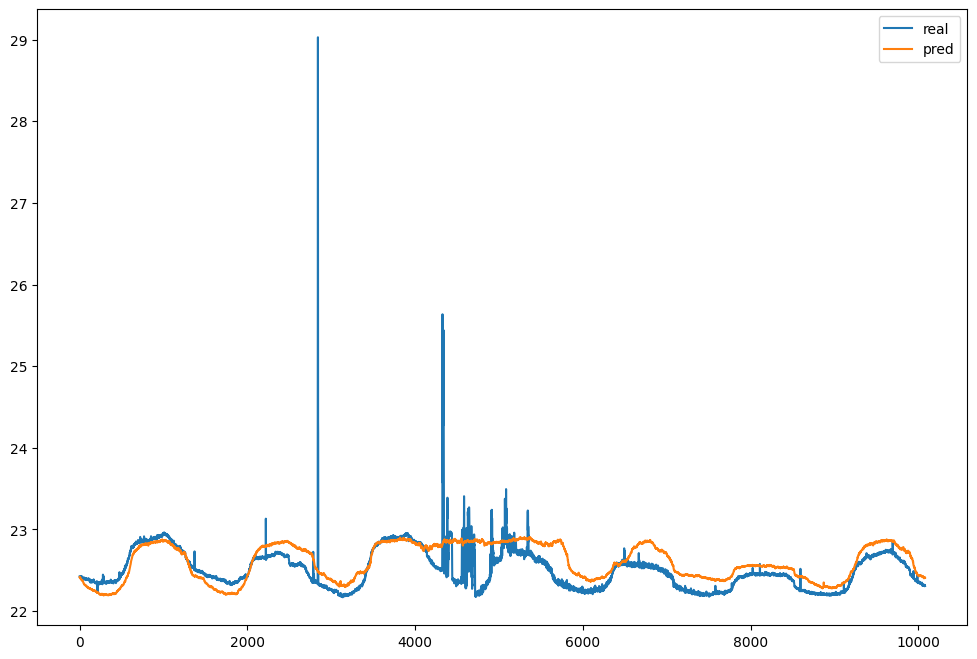

In [21]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),Test_data['value'],label='real')
axes.plot(np.arange(1,10081),pred,label='pred')
plt.legend()

In [22]:
pred

array([22.41517 , 22.412449, 22.413738, ..., 22.414934, 22.41089 ,
       22.409674], dtype=float32)

In [23]:
actuals= torch.FloatTensor(Test_data['value'].values).view(1,-1)
actuals

tensor([[22.4239, 22.4145, 22.4160,  ..., 22.3182, 22.3100, 22.3072]])

In [24]:
print('smape',SMAPE()(new_raw_pred,actuals).item()*100,'%')
print('rmse',RMSE()(new_raw_pred,actuals).item())

smape 0.6901664659380913 %
rmse 0.2205694168806076


https://pycj92.tistory.com/25<br>
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/deepar.html